# BB84 Quantum Key Distribution

This notebook demonstrates the BB84 Quantum Key Distribution protocol from Chapter 5, Single-Qubit Quantum Gates.

<a href="https://mybinder.org/v2/gh/Polaris-QCI/Quantum-Computing-and-Information-ed2/main?labpath=Qiskit%2F05-Single-Qubit-Quantum-Gates%2Fbb84-quantum-key-distribution-demo.ipynb" target="_blank" rel="noopener noreferrer"><img src="https://mybinder.org/badge_logo.svg" alt="Open In Binder"></a>
<a href="https://colab.research.google.com/github/Polaris-QCI/Quantum-Computing-and-Information-ed2/blob/main/Qiskit/05-Single-Qubit-Quantum-Gates/bb84-quantum-key-distribution-demo.ipynb" target="_blank" rel="noopener noreferrer"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>

## 0. Setup

The cells below install the packages and import the libraries needed by this demo.

In [ ]:
#@title Install Qiskit and other dependencies
%pip install matplotlib pandas qiskit qiskit-aer qiskit-ibm-runtime pylatexenc

In [2]:
# Imports

from IPython.display import display, Markdown
from math import cos, sin, pi as π
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.circuit import ClassicalRegister, QuantumCircuit, QuantumRegister
import pandas as pd
import matplotlib.pyplot as plt

## 1. Quantum Random Number Generator

The following cell defines a Quantum Random Number Generator (QRNG) circuit. This circuit generates a random bit by preparing a qubit in the state $|+\rangle$, then measuring it in the $Z$ basis.

*Note*: The sample circuits in this repository use the Qiskit AER simulator. 
As such, all quantum randomness is simulated, actually using a deterministic pseudo-random number generator.
However, these same circuits could in principle be run on a real quantum computer to generate true quantum randomness.

In [3]:
def qrng():
    """
    Generate a random bit using a quantum random number generator (QRNG).

    This function creates a quantum circuit with a single qubit, applies a Hadamard gate to put the qubit
    into a superposition state, and then measures the qubit. The result is a random bit (0 or 1) due to
    the inherent randomness of quantum measurement.

    Returns:
        int: A random bit (0 or 1) generated by the quantum circuit.
    """
    q = QuantumRegister(1)
    circuit = QuantumCircuit(q)
    circuit.h(q)
    circuit.measure_all()
    counts = AerSimulator().run(circuit).result().get_counts()
    return int(list(counts.keys())[0])


bits = [qrng() for _ in range(8)]
display(Markdown(f"Random bits: {bits}"))

Random bits: [0, 1, 1, 1, 1, 0, 1, 1]

## 2. BB84 bit

The next cell defines a routine that generates a circuit that computes observations on a single qubit for Alice, Bob and optionally, Eve.

In [4]:
def bb84_bit(eavesdropper=False):
    q = [q0] = QuantumRegister(1, 'q')
    c_alice = ClassicalRegister(1, 'alice')
    c_bob = ClassicalRegister(1, 'bob')
    if eavesdropper:
        c_eve = ClassicalRegister(1, 'eve')
        circuit = QuantumCircuit(q, c_alice, c_eve, c_bob)
    else:
        circuit = QuantumCircuit(q, c_alice, c_bob)

    if qrng():
        circuit.h(q0)

    alice_basis = 'DA' if qrng() else 'HV'
    if alice_basis == 'DA':
        circuit.h(q0)
    circuit.measure(q, c_alice)

    if eavesdropper:
        eve_basis = 'DA' if qrng() else 'HV'
        if eve_basis == 'DA':
            circuit.h(q0)
        circuit.measure(q, c_eve)

    bob_basis = 'DA' if qrng() else 'HV'
    if bob_basis != alice_basis:
        circuit.h(q0)
    circuit.measure(q, c_bob)

    simulator = AerSimulator()
    sampler = Sampler(simulator)
    job = sampler.run([circuit], shots=1)
    result = job.result()
    alice_result = next(iter(result[0].data.alice.get_counts().keys()))
    bob_result = next(iter(result[0].data.bob.get_counts().keys()))
    if eavesdropper:
        eve_result = next(iter(result[0].data.eve.get_counts().keys()))
        return {
            'alice_basis': alice_basis,
            'alice_result': alice_result,
            'eve_basis': eve_basis,
            'eve_result': eve_result,
            'bob_basis': bob_basis,
            'bob_result': bob_result
        }
    else:
        return {
            'alice_basis': alice_basis,
            'alice_result': alice_result,
            'bob_basis': bob_basis,
            'bob_result': bob_result
        }


## 3. Key sifting

In [16]:
output =  "| # | Alice's basis | Alice's bit | Bob's basis | Bob's bit | Basis Match | Key Bit |\n"
output += "|---|---------------|-------------|-------------|-----------|-------------|---------|\n"
for i in range(20):
    results = bb84_bit()
    alice_basis = results['alice_basis']
    alice_result = results['alice_result']
    bob_basis = results['bob_basis']
    bob_result = results['bob_result']
    basis_match = "✓" if results['alice_basis'] == results['bob_basis'] else "✗"
    key_bit = alice_result if basis_match == "✓" else " "
    output += f"| {i+1} | {alice_basis} | {alice_result} | {bob_basis} | {bob_result} | {basis_match} | {key_bit} |\n"

display(Markdown(output))

| # | Alice's basis | Alice's bit | Bob's basis | Bob's bit | Basis Match | Key Bit |
|---|---------------|-------------|-------------|-----------|-------------|---------|
| 1 | DA | 0 | DA | 0 | ✓ | 0 |
| 2 | DA | 1 | HV | 1 | ✗ |   |
| 3 | HV | 0 | DA | 0 | ✗ |   |
| 4 | HV | 1 | HV | 1 | ✓ | 1 |
| 5 | DA | 0 | HV | 0 | ✗ |   |
| 6 | HV | 0 | DA | 0 | ✗ |   |
| 7 | DA | 0 | HV | 0 | ✗ |   |
| 8 | DA | 0 | HV | 1 | ✗ |   |
| 9 | HV | 1 | HV | 1 | ✓ | 1 |
| 10 | DA | 0 | HV | 0 | ✗ |   |
| 11 | DA | 1 | DA | 1 | ✓ | 1 |
| 12 | DA | 1 | DA | 1 | ✓ | 1 |
| 13 | DA | 0 | DA | 0 | ✓ | 0 |
| 14 | HV | 0 | HV | 0 | ✓ | 0 |
| 15 | HV | 0 | DA | 1 | ✗ |   |
| 16 | HV | 1 | DA | 1 | ✗ |   |
| 17 | DA | 0 | HV | 1 | ✗ |   |
| 18 | DA | 0 | DA | 0 | ✓ | 0 |
| 19 | DA | 1 | DA | 1 | ✓ | 1 |
| 20 | HV | 0 | HV | 0 | ✓ | 0 |


## 4. Eavesdropper detection mechanism

Below, the eavedropper is included. If enough bits are included, the eavesdropper will be detected on at least one bit where Alice and Bob chose the same basis but got a different result.

In [6]:
eavesdropper_detected = False
output =  "| # | Alice's basis | Bob's basis | Basis Match | Alice's results | Eve's basis | Eve's results | Bob's results | Eaves check |\n"
output += "|---|---------------|-------------|-------------|-----------------|-------------|---------------|---------------|-------------|\n"
for i in range(20):
    results = bb84_bit(True)
    alice_basis = results['alice_basis']
    bob_basis = results['bob_basis']
    basis_match = "✓" if alice_basis == bob_basis else " "
    alice_result = results['alice_result']
    eve_basis = results['eve_basis']
    eve_result = results['eve_result']
    bob_result = results['bob_result']
    if alice_basis != bob_basis:
        eavesdropper_check = " "
    else:
        if alice_result == bob_result:
            eavesdropper_check = "✓"
        else:
            eavesdropper_detected = True
            eavesdropper_check = "✗"
    output += f"| {i+1} | {alice_basis} | {bob_basis} | {basis_match} | {alice_result} | {eve_basis} | {eve_result} | {bob_result} | {eavesdropper_check} | \n"

display(Markdown(output))

if eavesdropper_detected:
    display(Markdown("Because there was at least one mismatch between Alice's and Bob's results, the eavesdropper was detected."))
else:
    display(Markdown("There were no mismatches between Alice's and Bob's results, so the eavesdropper was not detected."))

| # | Alice's basis | Bob's basis | Basis Match | Alice's results | Eve's basis | Eve's results | Bob's results | Eaves check |
|---|---------------|-------------|-------------|-----------------|-------------|---------------|---------------|-------------|
| 1 | HV | DA |   | 0 | HV | 0 | 0 |   | 
| 2 | DA | HV |   | 0 | HV | 0 | 1 |   | 
| 3 | DA | HV |   | 0 | DA | 1 | 0 |   | 
| 4 | HV | DA |   | 0 | DA | 0 | 0 |   | 
| 5 | DA | HV |   | 1 | DA | 1 | 0 |   | 
| 6 | DA | HV |   | 0 | DA | 1 | 0 |   | 
| 7 | HV | DA |   | 0 | DA | 1 | 0 |   | 
| 8 | DA | HV |   | 1 | HV | 1 | 0 |   | 
| 9 | DA | HV |   | 0 | HV | 0 | 1 |   | 
| 10 | HV | HV | ✓ | 1 | DA | 0 | 0 | ✗ | 
| 11 | HV | HV | ✓ | 0 | DA | 0 | 0 | ✓ | 
| 12 | DA | DA | ✓ | 0 | HV | 0 | 0 | ✓ | 
| 13 | HV | DA |   | 0 | HV | 0 | 1 |   | 
| 14 | DA | DA | ✓ | 0 | DA | 0 | 0 | ✓ | 
| 15 | HV | DA |   | 0 | DA | 0 | 0 |   | 
| 16 | DA | HV |   | 0 | HV | 0 | 1 |   | 
| 17 | HV | HV | ✓ | 0 | DA | 1 | 1 | ✗ | 
| 18 | HV | HV | ✓ | 0 | HV | 0 | 0 | ✓ | 
| 19 | DA | DA | ✓ | 0 | DA | 0 | 0 | ✓ | 
| 20 | DA | DA | ✓ | 0 | HV | 0 | 0 | ✓ | 


Because there was at least one mismatch between Alice's and Bob's results, the eavesdropper was detected.

## 5. Eavesdropper detection probability

Below, we run the eavesdropper detection with varying $n$ to confirm that with $n$ detection bits, the eavesdropper is detected with probability
$$
P(\text{Detection of Eve with $n$ check bits}) = 1 - \left(\frac{3}{4}\right)^n
$$

Text(0.5, 1.0, 'Eavesdropper detection probability in BB84 protocol')

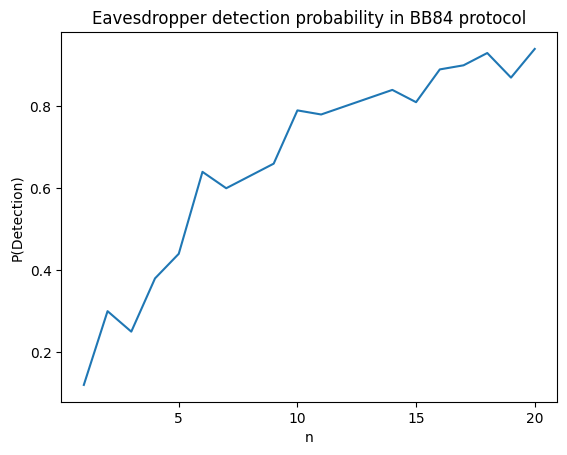

In [12]:
# Note: this cell takes some time to compute. More than a minute on my machine.
data = []
trials = 100
for n in range(1, 21):
    eavesdropper_detected_count = 0
    for trial in range(trials):
        for i in range(n):
            results = bb84_bit(True)
            alice_basis = results['alice_basis']
            bob_basis = results['bob_basis']
            alice_result = results['alice_result']
            bob_result = results['bob_result']
            if alice_basis == bob_basis and alice_result != bob_result:
                eavesdropper_detected_count += 1
                break
    probability = eavesdropper_detected_count / trials
    data.append([n, probability])

df = pd.DataFrame(data, columns=['n', 'P'])
plt.plot(df['n'], df['P'])
plt.xticks([5, 10, 15, 20])
plt.xlabel('n')
plt.ylabel('P(Detection)')
plt.title('Eavesdropper detection probability in BB84 protocol')
